## Symbolic data processing, Turkish music case

In this notebook, the SymTr data (Turkish Makam Music Symbolic Data Collection) (http://compmusic.upf.edu/node/140 , https://github.com/MTG/SymbTr) is used. Here we demonstrate accessing pieces in a specific form and makam, reading a specific a section of the form and ploting the melodic curves. The makams are chosen to apply the same scale but different melodic progressions ('seyir'). 


The following steps are carried:
- Downloading SymbTr data from the github repo
- Printing a list of makams and forms sorted with respect to the number of files in those categories
- Plotting melodic curves from the first sections in saz-semaisi form in two makams: rast and mahur.


In [1]:
import collections
import csv
import glob
import os
import urllib.request
import zipfile

import numpy as np
import matplotlib.pyplot as plt

### Downloading SymbTr data

Set this value to `True` to download the supporting data, or to `False` if you have already downloaded it

This archive is about 20MB in size

In [2]:
downloadData = True

In [3]:
baseDir = os.path.join('..', 'data', 'compMusicDatasets', 'turkishMakam')

zip_folder = 'SymbTr-2.0.0'
dataDir = os.path.join(baseDir, zip_folder)
if downloadData:
    os.makedirs(dataDir, exist_ok=True)

    url = 'https://github.com/MTG/SymbTr/archive/v2.0.0.zip'
    filename = 'SymbTr-2.0.0.zip'
    # Downloading the SymbTr archive and uncompress it
    urllib.request.urlretrieve(url, filename)
    zip_ref = zipfile.ZipFile(filename, 'r')
    zip_ref.extractall(baseDir)
    zip_ref.close()
    # Clean up downloaded archive
    os.remove(filename)
    
    print('Data downloaded and unzipped to: {}'.format(dataDir))
else:
    print('Not downloading data due to request')
    if not os.path.exists(dataDir):
        print("Warning: directory {} doesn't exist (was it downloaded?)".format(dataDir))

Data downloaded and unzipped to: ../data/compMusicDatasets/turkishMakam/SymbTr-2.0.0


#### Grouping files with respect to makams, printing a short sorted table


In [4]:
#Function definitions
def printSortedList(file_dict, numCategories = 5):
    '''Prints list of categories sorted in terms of number of files contained
    
    Args:
        file_dict (dict): dictionary containing categories mapped to file list
        numCategories (int): number of categories  
    '''
    counter = collections.Counter()
    for cat, files in file_dict.items():
        counter[cat] = len(files)
        
    categories = counter.most_common(numCategories)
    max_length = max([len(m) for m in dict(categories).keys()])
    for category, count in categories:
        print('{category:<{pad}} {count}'.format(category=category, pad=max_length, count=count))

def constructFileDict(fileList, tokenIndex):
    '''Constructs/returns dictionary that maps categories to file lists
    
    The file name of a SymbTr file is split into tokens according to the format of the SymbTr slug:
    makam--form--usul--title--composer
    
    Args:
        fileList (list): file list
        tokenIndex (int): category to be used for grouping the files
            Example: tokenIndex=0, the dictionary returned contains files grouped
            in makam categories (keys: makam name, values: file list for the makam).
    Outputs:
        fileDict (dict): dictionary mapping categories to file lists    
    '''
    fileDict = collections.defaultdict(list)
    for txtFile in fileList:
        txtFile = os.path.basename(txtFile)
        if '--' in txtFile:
            tokens = txtFile.split('--')
            if tokenIndex >= len(tokens):
                print('index too high')
                return
            category = tokens[tokenIndex]
            fileDict[category].append(txtFile)
    
    return fileDict

In [5]:
# Construct file lists and print
txtFilesList = glob.glob(os.path.join(dataDir, 'txt', '*.txt'))
makamsFileList = constructFileDict(txtFilesList, 0)
formsFileList = constructFileDict(txtFilesList, 1)

print('-' * 50)
print('Most frequently used modes in score collection ')
printSortedList(makamsFileList, 10)
print('-' * 50)
print('Most frequently used forms in score collection ')
printSortedList(formsFileList, 10)

--------------------------------------------------
Most frequently used modes in score collection 
hicaz           160
nihavent        128
ussak           119
rast            110
huzzam          96
segah           93
huseyni         91
mahur           88
hicazkar        79
kurdilihicazkar 70
--------------------------------------------------
Most frequently used forms in score collection 
sarki      991
turku      295
seyir      156
kupe       120
pesrev     93
sazsemaisi 82
aranagme   73
ilahi      41
beste      39
yuruksemai 38


### Plotting melodic curves
Below we plot first sections in saz-semaisi form in two makams: rast and mahur. 

In [6]:
def readInstrumentalSection(filePath, sectionStartStr = '1. HANE'):
    '''Reading notes of an instrumental section
    
    Args:
        filePath (str): file path
        sectionStartStr (str): section start label. 
            The section boundaries are marked in the lyrics column with specific indicators.
            Example: In saz-semaisi, '1. HANE' refers to the A section
    Outputs:
        notesSequence (list): note sequence as a list of tuples (midi number, duration) 
    '''
    file = open(filePath,'r')
    content = file.read()
    lines = content.split('\n')
    #Reading content
    notesSequence = []
    inSection = False
    # skip the first line
    for line in lines[1:]:
        tokens = line.split('\t')
        if(len(tokens) > 8):
            lyrics = tokens[11]
            if not inSection and sectionStartStr in line:
                inSection = True
            elif inSection and len(lyrics) > 0:
                # any lyrics non-empty is considered a section-end if section is already started
                inSection = False

            if inSection:
                intervalInHc = int(tokens[4])
                if intervalInHc > 0:
                    # conversion from Holderian commas to midi number
                    midiNumber = intervalInHc*(1200/53)/100
                else:
                    # pause represented with midi number = -1
                    midiNumber = -1
                notesSequence.append((midiNumber, int(tokens[8])))
    return notesSequence

def melodicCurveFromNotesSequence(notesSequence, totalNumPoints = 1000):
    '''Constructing melodic curve from note sequence with a fixed size 
    
    Duration is scaled accordingly to match totalNumPoints
    
    Args:
        notesSequence (list): note sequence as a list of tuples (midi number, duration)
        totalNumPoints (int): total number of points to represent the melodic curve
    Outputs:   
        numpy array containing samples(in midi numbers) of a melody sequence
    '''
    totalDuration = 0
    for note, duration in notesSequence:
        totalDuration += duration
    
    durationUnit = totalDuration/totalNumPoints
    melograph = []
    for note,duration in notesSequence:
        if note > 0:
            # pauses are discarded
            # due to this rounding, totalNumPoints will not be exactly matched
            numPoints = int(duration/durationUnit)
            melograph += ([note]*numPoints)
    return np.array(melograph)

Files in makam rast and form sazsemaisi
['rast--sazsemaisi--aksaksemai----kantemiroglu.txt', 'rast--sazsemaisi--aksaksemai----benli_hasan_aga.txt']
Files in makam mahur and form sazsemaisi
['mahur--sazsemaisi--aksaksemai----nikolaki.txt', 'mahur--sazsemaisi--aksaksemai--bahar_1--goksel_baktagir.txt', 'mahur--sazsemaisi--aksaksemai----refik_talat_alpman.txt', 'mahur--sazsemaisi--aksaksemai----gazi_giray_han.txt']


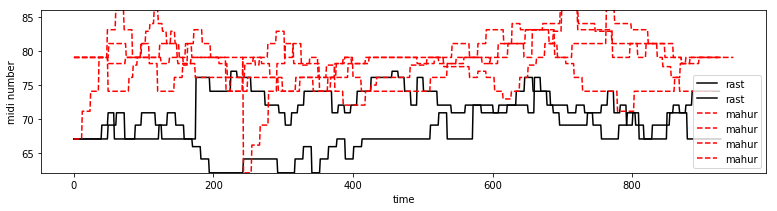

In [7]:
def filelist_for_makam_and_form(fileList, makam, form):
    '''Selects/returns a file list (a subset of the whole list: 'fileList') 
    given the filters: makam(str) and form(str)'''
    selectedFiles = []
    for filepath in fileList:
        filename = os.path.basename(filepath)
        if filename.split('--')[0] == makam and filename.split('--')[1] == form:
            selectedFiles.append(filepath)
    return selectedFiles

#Let's pick two makams only differing in seyir and plotting melodic curves 
# for first sections in the sazsemaisi form
makams = ['rast', 'mahur']
form = 'sazsemaisi'
sectionStartStr = '1. HANE'#section's start indicator (in lyrics)

plt.figure(figsize=(13, 3))
# plotting color options for different makams
colors=['k', 'r--', 'b.', 'g.']
# a high interval value to be updated with min value observed
minInterval = 400
# a low interval value to be updated with max value observed
maxInterval = 0
for index, makam in enumerate(makams):
    selectedFileList = filelist_for_makam_and_form(txtFilesList, makam, form)
    print('Files in makam {} and form {}'.format(makam, form))
    print([os.path.basename(f) for f in selectedFileList])
    for symbTrFile in selectedFileList:
        # Read notes of a section (section starting with sectionStartStr in lyrics, ending with any non-empty lyric)
        notesSequence = readInstrumentalSection(symbTrFile, sectionStartStr)
        if len(notesSequence) > 0:
            #print(symbTrFile)
            #print('-----------------------')
            melograph = melodicCurveFromNotesSequence(notesSequence)
            plt.plot(melograph, colors[index], label=makam)
            minInterval = min(np.min(melograph), minInterval)
            maxInterval = max(np.max(melograph), maxInterval)

plt.ylim([minInterval, maxInterval])
plt.ylabel('midi number')
plt.xlabel('time')
plt.legend()

#### Note that the midi numbers are fractional. Here is part of a note sequence

In [8]:
print('Sample note sequence:')
print('List of (midi number, duration), midi=-1 refers to silence','\n')
print(notesSequence[:10])

Sample note sequence:
List of (midi number, duration), midi=-1 refers to silence 

[(79.0188679245283, 1176), (81.0566037735849, 588), (79.0188679245283, 1176), (78.11320754716981, 294), (79.0188679245283, 294), (78.11320754716981, 588), (76.0754716981132, 1176), (74.0377358490566, 588), (76.0754716981132, 1176), (74.0377358490566, 588)]
